In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
import itertools
import importlib

In [3]:
from training import toy
importlib.reload(toy)
torch.manual_seed(42)

batch_size = 2

trainset = toy.CubicToyDataset(min=-4, max=4, sample_count=20, noise=3, normalize=True)
#trainset = toy.TrigonometricToyDataset(sample_count=200, normalize=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

device = torch.device("cpu")

In [4]:
import matplotlib.pyplot as plt

def plot(eval):
    plt.xlim(-6, 6)
    plt.ylim(-150, 250)
    t = torch.linspace(-6, 6, 50)
    #plt.xlim(-0.2, 1.2)
    #plt.ylim(-0.4, 1.2)
    #t = torch.linspace(-0.2, 1.2, 100)

    plt.plot(t, trainset.eval_value(t), color="blue") # Actual function

    means, variances = torch.zeros(len(t)), torch.zeros(len(t))
    with torch.no_grad():
        means, variances = eval(torch.unsqueeze(t * trainset.x_norm, -1))
    means = torch.squeeze(means, -1) / trainset.y_norm
    variances = torch.squeeze(variances, -1) / trainset.y_norm**2

    higher_bound = means + 3 * torch.sqrt(variances)
    lower_bound = means - 3 * torch.sqrt(variances)
    plt.plot(t, means, color="red") # Averaged predictions
    plt.fill_between(t, lower_bound, higher_bound, color="lightgrey")
    print(f"RMSE {torch.sqrt(F.mse_loss(means, t**3))}")

    xs, ys = zip(*(((x / trainset.x_norm).numpy(), (y / trainset.y_norm).numpy()) for (x, y) in trainset))
    plt.scatter(xs, ys, s=4, color="blue")

Epoch 0: loss 0.20535850524902344
Epoch 10: loss 0.00787082128226757
Epoch 20: loss 0.006018802523612976
Epoch 30: loss 0.004925227724015713
Epoch 40: loss 0.004062673542648554
Epoch 50: loss 0.0036063282750546932
Epoch 60: loss 0.0031791594810783863
Epoch 70: loss 0.0029627480544149876
Epoch 80: loss 0.0028402674943208694
Epoch 90: loss 0.0026777428574860096
Final loss 0.0026222653687000275
RMSE 88.65095520019531


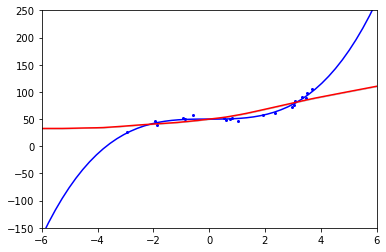

In [5]:
# Point estimator with L2 regularization

torch.manual_seed(42)

model = nn.Sequential(
    nn.Linear(1, 16), 
    nn.ReLU(), 
    nn.Linear(16, 16), 
    nn.ReLU(), 
    nn.Linear(16, 16), 
    nn.ReLU(), 
    nn.Linear(16, 1)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
for epoch in range(100):
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")
plot(lambda input: (model(input), torch.tensor(0)))

In [ ]:
# SWAG trained with SGD and L2 regularization (lr is currently not adjusted for SWAG)

from training import swag
importlib.reload(swag)

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 1))
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001) # Without weight_decay the covariance matrix is not positive definit???
wrapper = swag.SWAGWrapper(model, 5, 10)
for epoch in range(40):
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    wrapper.update(epoch)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_swag(input):
    return wrapper.sample(input, 100, model, 1)

plot(eval_swag)

Training model 0
  Final loss -2.016819477081299
Training model 1
  Final loss -2.98551607131958
Training model 2
  Final loss -2.1268856525421143
Training model 3
  Final loss -2.4193649291992188
Training model 4
  Final loss -2.3387954235076904
RMSE 98.94270324707031


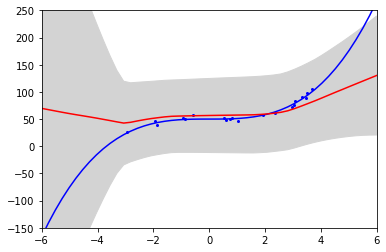

In [8]:
# Ensemble of point estimators with L2 regularization

from training import ensemble
importlib.reload(ensemble)

torch.manual_seed(42)

adversarial_training = True

def nll_loss(mean, variance, target):
    return (torch.log(variance) / 2 + torch.pow(target - mean, 2) / (2 * variance)).sum() / mean.shape[0]

ensemble_count = 5
models = [nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 2)) for _ in range(ensemble_count)]

for i, model in enumerate(models):
    print(f"Training model {i}")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
    for epoch in range(100):
        epoch_loss = torch.tensor(0, dtype=torch.float)
        for data, target in trainloader:
            optimizer.zero_grad()
            if adversarial_training:
                data.requires_grad = True

            output = model(data)
            mean, variance = output[:, 0], torch.log1p(torch.exp(output[:, 1])) + 1e-6
            loss = nll_loss(mean, variance, target)

            if adversarial_training:
                loss.backward(retain_graph=True)
                a_data = data + 0.01 * torch.sign(data.grad)
                optimizer.zero_grad()
                a_output = model(data)
                a_mean, a_variance = a_output[:, 0], torch.log1p(torch.exp(a_output[:, 1])) + 1e-6
                a_loss = nll_loss(a_mean, a_variance, target)
                loss += a_loss

            loss.backward()
            optimizer.step()
            epoch_loss += loss
        #if epoch % 10 == 0:
            #print(f"  Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
    print(f"  Final loss {epoch_loss / (len(trainloader) * batch_size)}")


def eval_esemble(input):
    return ensemble.combined_variance_output(input, models)


plot(eval_esemble)

Epoch 0: loss 21.056459426879883
Epoch 10: loss 25.752086639404297
Epoch 20: loss 24.575027465820312
Epoch 30: loss 23.642019271850586
Epoch 40: loss 22.73755645751953
Epoch 50: loss 22.20747184753418
Epoch 60: loss 22.342525482177734
Epoch 70: loss 22.254657745361328
Epoch 80: loss 21.65571403503418
Epoch 90: loss 21.777679443359375
Epoch 100: loss 22.636369705200195
Epoch 110: loss 23.10897445678711
Epoch 120: loss 24.245330810546875
Epoch 130: loss 24.31015968322754
Epoch 140: loss 24.367141723632812
Epoch 150: loss 28.780603408813477
Epoch 160: loss 30.117488861083984
Epoch 170: loss 29.677669525146484
Epoch 180: loss 29.381576538085938
Epoch 190: loss 28.312082290649414
Epoch 200: loss 30.501514434814453
Epoch 210: loss 29.520084381103516
Epoch 220: loss 28.6535701751709
Epoch 230: loss 27.824514389038086
Epoch 240: loss 28.050426483154297
Epoch 250: loss 27.937137603759766
Epoch 260: loss 29.50931167602539
Epoch 270: loss 30.084163665771484
Epoch 280: loss 30.429025650024414
Epoc

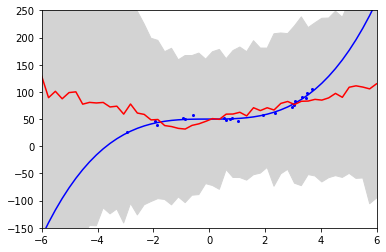

In [220]:
# Bayesian NN (Bayes-by-Backprop)

from training import bbb, util
importlib.reload(bbb)
importlib.reload(util)

torch.manual_seed(42)
torch.autograd.set_detect_anomaly(True)

pi = 0.5  # 0.25, 0.5, 0.75
sigma1 = np.exp(-1)  # 0, 1, 2
sigma2 = np.exp(-7)  # 6, 7, 8
prior = util.GaussianMixture(pi, sigma1, sigma2)
#prior = torch.distributions.Normal(0, 0.5)

model = nn.Sequential(
    bbb.BBBLinear(1, 100, prior, prior, device),
    nn.ReLU(),
    bbb.BBBLinear(100, 1, prior, prior, device)
)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

for epoch in range(1000):
    loss = bbb.run_bbb_epoch(model, optimizer, loss_fn, trainloader, device)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {loss / (len(trainloader) * batch_size)}")
print(f"Final loss {loss / (len(trainloader) * batch_size)}")


def eval_bbb(input):
    samples = 100
    outputs = torch.zeros((input.shape[0], samples))
    with torch.no_grad():
        model.eval()
        for i in range(samples):
            outputs[:, i] = torch.squeeze(model(input), -1)
    return torch.mean(outputs, dim=1), torch.var(outputs, dim=1)


plot(eval_bbb)